# MNIST Classification

## Preliminaries

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Dataset: MNIST

In [10]:
img_size = 32
ds_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))
ds_train = torch.utils.data.Subset(ds_train, random.sample(range(len(ds_train)), len(ds_train)//3))

ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

def Draw_randomly(ds):
    plt.figure(figsize=(15,17))
    for i in range(100):
        plt.subplot(10,10,i+1)
        r = random.randint(0, len(ds))
        Draw(ds[r][0])
    plt.show()

In [11]:
ds_train_blur_m = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x)),
                            ]))
ds_train_blur_m = torch.utils.data.Subset(ds_train_blur_m, random.sample(range(len(ds_train_blur_m)), len(ds_train_blur_m)//3))
ds_train_blur_l = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x)),
                            ]))
ds_train_blur_l = torch.utils.data.Subset(ds_train_blur_l, random.sample(range(len(ds_train_blur_l)), len(ds_train_blur_l)//3))

In [12]:
ds_h = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.RandomHorizontalFlip(p=1),
                            torchvision.transforms.ToTensor(),
                            ]))
idx = ((ds_h.targets == 2) | (ds_h.targets == 4) | (ds_h.targets == 5) | (ds_h.targets == 6)
        | (ds_h.targets == 7) | (ds_h.targets == 8) | (ds_h.targets == 9))
ds_h.data = ds_h.data[idx]
ds_h.targets = ds_h.targets[idx]
ds_h = torch.utils.data.Subset(ds_h, random.sample(range(len(ds_h)), len(ds_h)//3))

ds_v = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.RandomVerticalFlip(p=1),
                            torchvision.transforms.ToTensor(),
                            ]))
idx = ((ds_v.targets == 2) | (ds_v.targets == 3) | (ds_v.targets == 4) | (ds_v.targets == 5)
        | (ds_v.targets == 7))
ds_v.data = ds_v.data[idx]
ds_v.targets = ds_v.targets[idx]
ds_v = torch.utils.data.Subset(ds_v, random.sample(range(len(ds_v)), len(ds_v)//3))

In [13]:
ds = ds_train + ds_train_blur_m + ds_train_blur_l + ds_h + ds_v

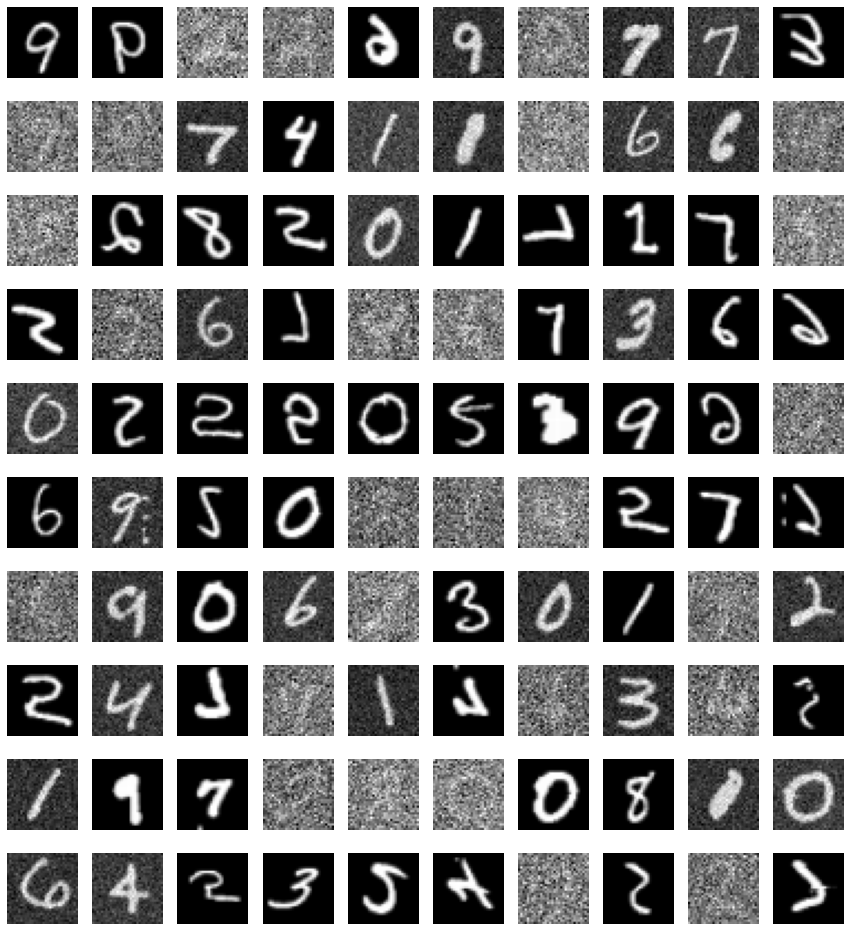

In [14]:
Draw_randomly(ds)

## DataLoaders

In [15]:
# Batched, for training
batch_size = 128

train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True)

## VGG11

In [16]:
class VGG11(nn.Module):

    def __init__(self):
        super().__init__()
        self.to(device)
        self.network = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(start_dim=1),
            
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=4096, out_features=10),
           # nn.LogSoftmax(dim = -1)
        )
        self.loss_fcn = nn.CrossEntropyLoss()
      #  self.loss_fcn = nn.NLLLoss()
        self.train_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.test_accuracy = []

    def forward(self, x):
        activation = nn.LogSoftmax(dim = -1)
        prediction = activation(self.network(x))
        prediction = self.network(x)
        return torch.argmax(prediction, dim = 1)
    
    def accuracy_loss(self, dl):
        self.eval()
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for x,t in dl:
                x.to(device)
                t.to(device)
                result = self(x)
                total_loss += self.loss_fcn(self.network(x), t).item()*len(t)
                correct += torch.sum(result == t).item()
        return correct/len(dl.dataset), total_loss/len(dl.dataset)

    def plot(self):
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        plt.yscale('log')
        plt.title('Loss');
        plt.plot(self.train_losses); 
        plt.plot(self.test_losses);
        plt.legend(['Train Loss', 'Test Loss'])

        plt.subplot(1,2,2)
        plt.title('Accuracy');
        plt.plot(self.train_accuracy)
        plt.plot(self.test_accuracy)
        plt.legend(['Train Accuracy', 'Test Accuracy'])
        plt.show()
    
    def learn(self, dl_train, dl_test, epochs=10, lr = 0.001):
        #optimizer_network = torch.optim.Adam(self.network.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizer_network = torch.optim.Adam(self.network.parameters(), lr=lr)
        losses = []
        for epoch in tqdm(range(epochs)):
            self.train()
            for x, t in dl_train:
                x.to(device)
                t.to(device)
                y = self.network(x) # forward pass
                loss = self.loss_fcn(y, t)
                optimizer_network.zero_grad()
                loss.backward()
                optimizer_network.step()
                
                losses.append(loss * len(t))
            #train_accuracy, train_loss = self.accuracy_loss(dl_train)
            #test_accuracy, test_loss = self.accuracy_loss(dl_test)
            #self.train_losses.append(train_loss)
            #self.test_losses.append(test_loss)
            #self.train_accuracy.append(train_accuracy)
            #self.test_accuracy.append(test_accuracy)
        # Plot the mini-batch loss to see training actually happened
        plt.plot(losses)
        plt.yscale('log')

# Create and train the network

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 5/5 [3:39:25<00:00, 2633.05s/it]


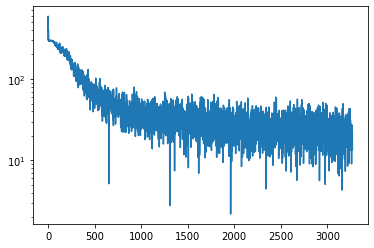

In [9]:
net = VGG11()
net.learn(train_dl, test_dl, 5, 0.001)

# Testing the network

## Horizontal Filp

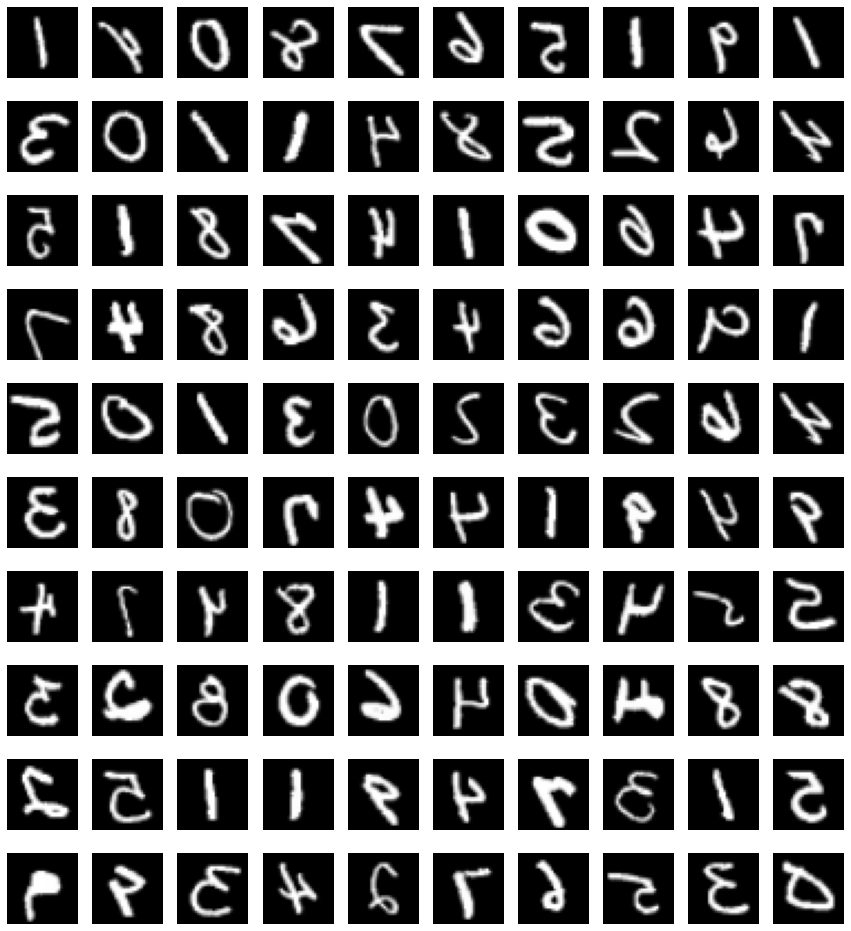

In [11]:
ds_test_h_flip = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.RandomHorizontalFlip(p=1),
                            torchvision.transforms.ToTensor(),
                            ]))
#ds_test_h_flip = torch.utils.data.Subset(ds_test_h_flip, range(100))
Draw_randomly(ds_test_h_flip)
dl_test_h_flip = torch.utils.data.DataLoader(ds_test_h_flip, batch_size=batch_size, shuffle=True)

In [12]:
acc, loss = net.accuracy_loss(dl_test_h_flip)
print("Accuracy of horizontal flipping is: ", acc*100, "%")

Accuracy of horizontal flipping is:  84.52 %


## Verticle Filp

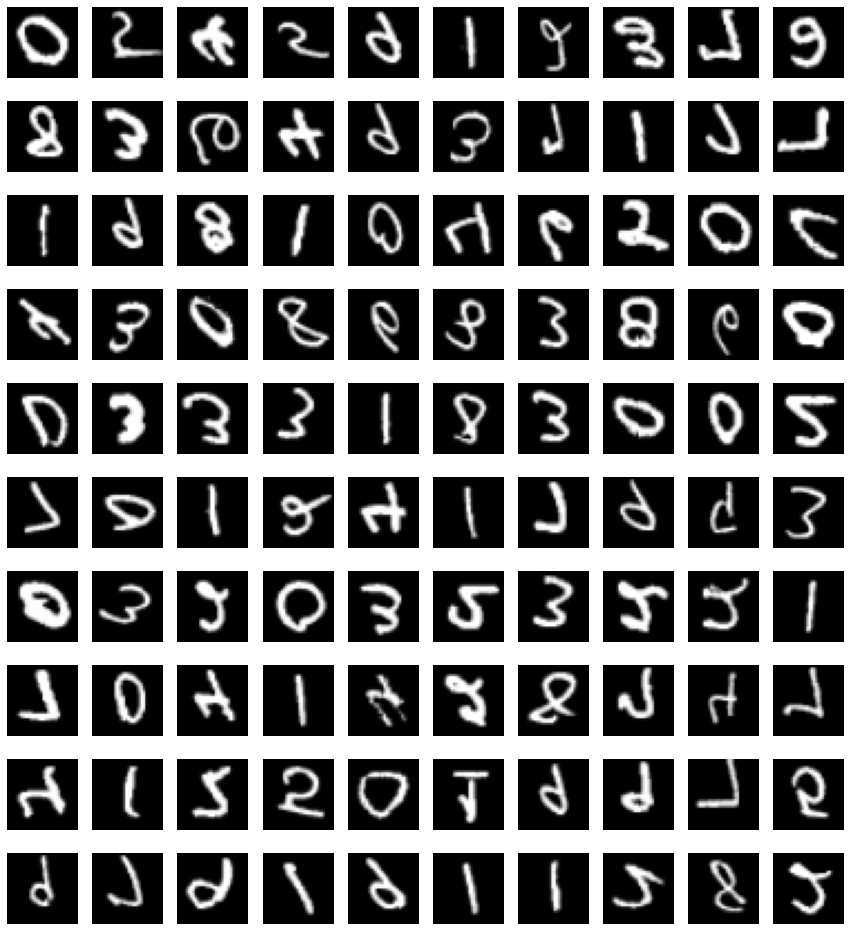

In [13]:
ds_test_v_flip = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.RandomVerticalFlip(p=1),
                            torchvision.transforms.ToTensor(),
                            ]))
#ds_test_v_flip = torch.utils.data.Subset(ds_test_v_flip, range(100))
Draw_randomly(ds_test_v_flip)
dl_test_v_flip = torch.utils.data.DataLoader(ds_test_v_flip, batch_size=batch_size, shuffle=True)

In [14]:
acc, loss = net.accuracy_loss(dl_test_v_flip)
print("Accuracy of vertical flipping is: ", acc*100, "%")

Accuracy of vertical flipping is:  69.34 %


## Blur - N(0, 0.01)

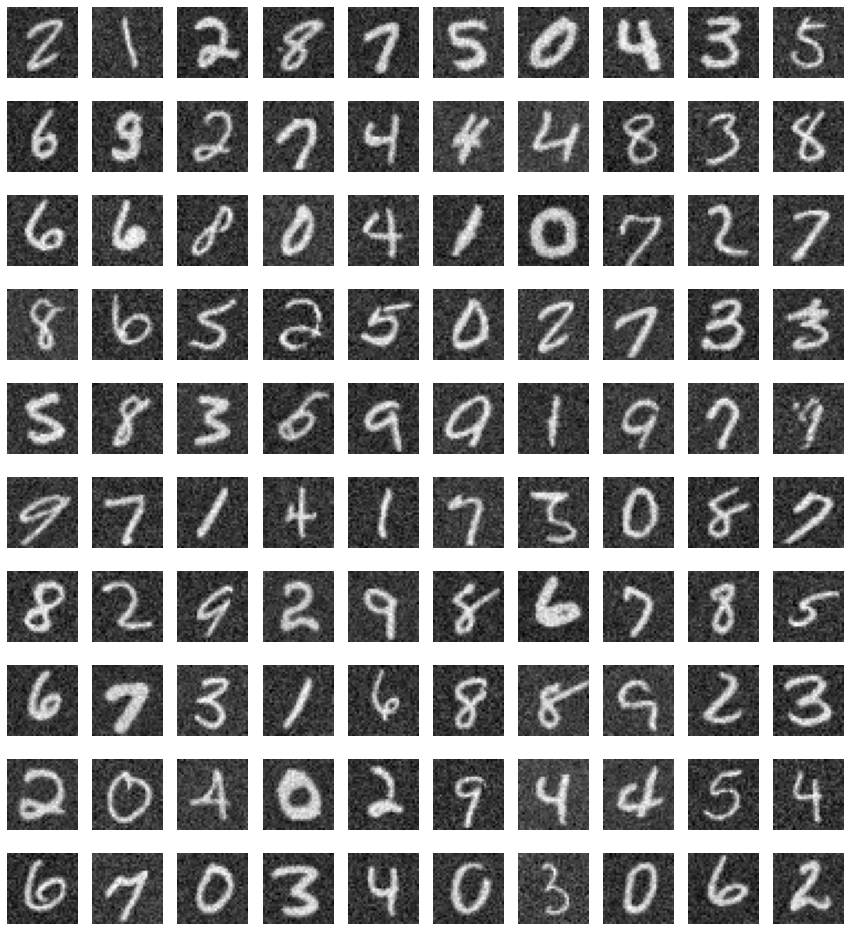

In [17]:
ds_test_blur_s = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x)),
                            ]))
#ds_test_blur_s = torch.utils.data.Subset(ds_test_blur_s, range(100))
Draw_randomly(ds_test_blur_s)
dl_test_blur_s = torch.utils.data.DataLoader(ds_test_blur_s, batch_size=batch_size, shuffle=True)

In [18]:
acc, loss = net.accuracy_loss(dl_test_blur_s)
print("Accuracy of blur 0.01 is: ", acc*100, "%")

Accuracy of blur 0.01 is:  98.36 %


## Blur - N(0, 0.1)

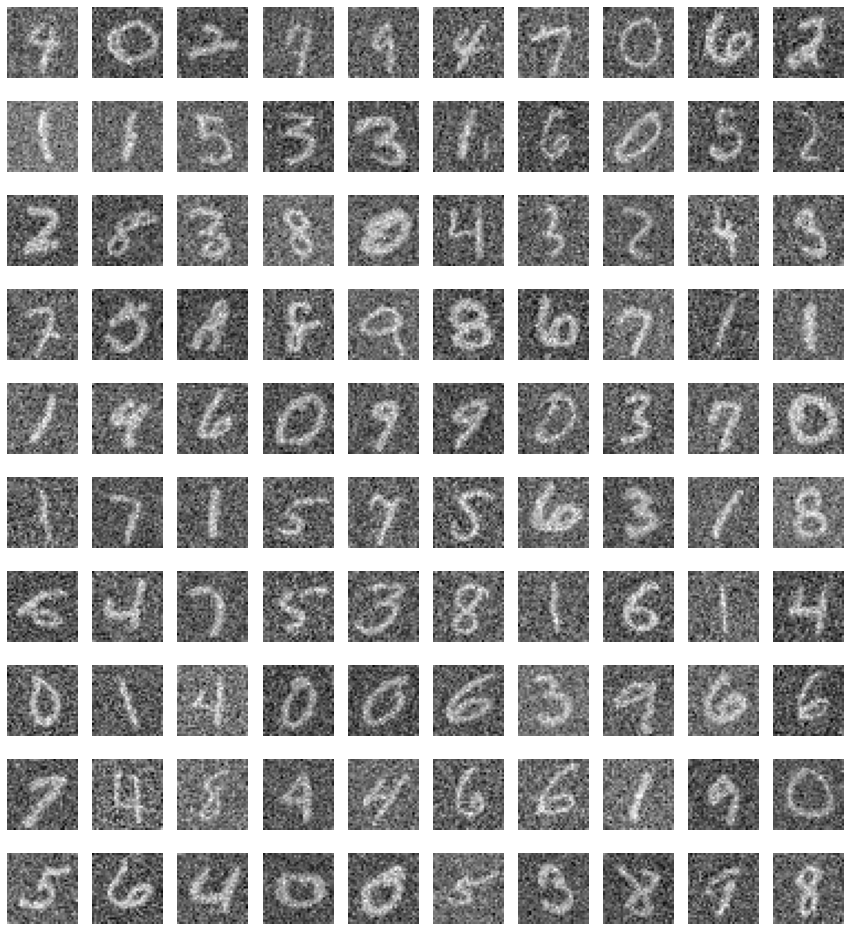

In [19]:
ds_test_blur_m = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(lambda x : x + np.sqrt(0.1)*torch.randn_like(x)),
                            ]))
#ds_test_blur_m = torch.utils.data.Subset(ds_test_blur_m, range(100))
Draw_randomly(ds_test_blur_m)
dl_test_blur_m = torch.utils.data.DataLoader(ds_test_blur_m, batch_size=batch_size, shuffle=True)

In [20]:
acc, loss = net.accuracy_loss(dl_test_blur_m)
print("Accuracy of blur 0.1 is: ", acc*100, "%")

Accuracy of blur 0.1 is:  97.61999999999999 %


## Blur - N(0, 1)

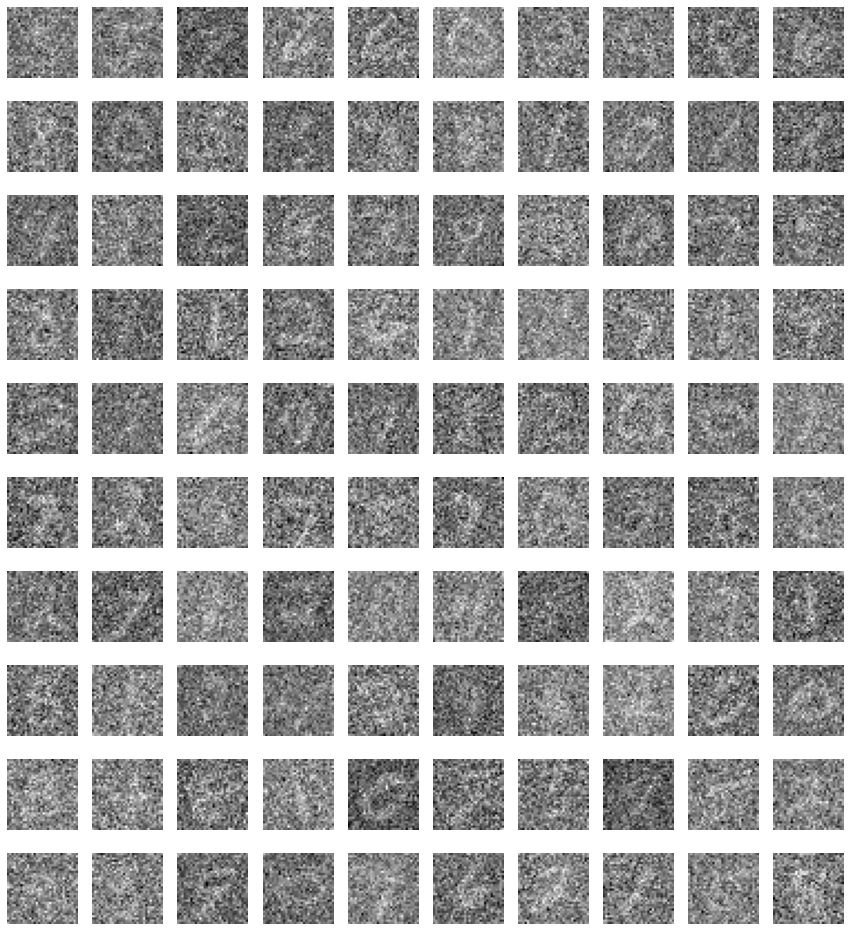

In [19]:
ds_test_blur_l = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x)),
                            ]))
#ds_test_blur_l = torch.utils.data.Subset(ds_test_blur_l, range(100))
Draw_randomly(ds_test_blur_l)
dl_test_blur_l = torch.utils.data.DataLoader(ds_test_blur_l, batch_size=batch_size, shuffle=True)

In [20]:
acc, loss = net.accuracy_loss(dl_test_blur_l)
print("Accuracy of blur 1 is: ", acc*100, "%")

Accuracy of blur 1 is:  85.64 %
